# Preare SST/Chloro DINEOF

In [31]:
using NCDatasets
using Statistics
using Dates
using PyPlot
const plt = PyPlot
push!(LOAD_PATH, "../../julia/")
using SST
using DINEOFtools
using DIVAnd
using Glob

## Files and directories
### SST

In [14]:
datamonthdir = "/home/ctroupin/data/SST/Global/monthly/"
dataclimdir = "/home/ctroupin/data/SST/Global/monthly_clim/"
outputdir = "/home/ctroupin/data/SST/Global/DINEOF/"
isdir(datamonthdir) & isdir(dataclimdir)

true

### Chloro

In [15]:
chlorodatamonthdir = "/home/ctroupin/data/Chloro/Global/"
outputdir = "/home/ctroupin/data/Chloro/Global/DINEOF"

"/home/ctroupin/data/Chloro/Global/DINEOF"

Create lists of files

In [16]:
sst_month_list = SST.get_sst_file_list(datamonthdir);
chloro_month_list = SST.get_sst_file_list(chlorodatamonthdir);

sst_clim_list = glob("*.nc", dataclimdir);
if length(sst_clim_list) != 12
    @warn("The list should contain 12 files")
end

[ Info: Found 273 files
[ Info: Found 274 files


## Main loop
Set satellite, sensor name and domain of interest (west, east, south, north).
### SST

In [8]:
sat = "TERRA"
sensor = "MODIS"
domain = [-96, 27, 21., 80.]
valex = -999.

lon, lat, sst = SST.read_sst_oceancolor_L3(sst_month_list[1], domain)
nlon = length(lon)
nlat = length(lat)

# Allocation
ntimes = length(sst_month_list)
sstanom = Array{Float64, 3}(undef, nlon, nlat, ntimes);
sstfield = Array{Float64, 3}(undef, nlon, nlat, ntimes);
times = Vector{Float32}(undef, ntimes);

@info("Problem size: $(nlon) X $(nlat) X $(ntimes)")

[ Info: Problem size: 1476 X 708 X 273


In [9]:
for (ii, datafiles) in enumerate(sst_month_list)
    @debug("Working on file $(basename(datafiles))")
    
    year, month = SST.get_year_month_file(datafiles)

    # According to the month, the monthly climatology covers a different period
    month == 1 ? yearstart = 2001 : yearstart = 2000
    month < 12 ? yearend = 2022 : yearend = 2021
    sstclimfile = SST.get_monthly_clim_filename(sat, sensor, yearstart, yearend, month; res="9km")
    
    #@info(sstclimfile);
    if (isfile(joinpath(dataclimdir, sstclimfile)))
        
        # Read climatological field
        lon, lat, sstclim = SST.read_sst_oceancolor_L3(joinpath(dataclimdir, sstclimfile), domain);
        # Read SST
        _, _, sst = SST.read_sst_oceancolor_L3(datafiles, domain)
        
        # Compute anomalies
        sst_anom = sst .- sstclim
        sst[isnan.(sst)] .= valex
        sst_anom[isnan.(sst_anom)] .= valex
        sstanom[:,:,ii] = sst_anom
        sstfield[:,:,ii] = sst
        
        # Extract date
        times[ii] = (Dates.Date(year, month) - Dates.Date(1981, 1, 1)).value
        
    else
        @error("File $(sstclimfile) not found")
    end
end

### Chloro

In [21]:
sat = "TERRA"
sensor = "MODIS"
domain = [-96, 27, 21., 80.]
valex = -999.

lon, lat, chloro = SST.read_chloro_oceancolor_L3(chloro_month_list[1], domain)
nlon = length(lon)
nlat = length(lat)

# Allocation
ntimes = length(chloro_month_list)
sstanom = Array{Float64, 3}(undef, nlon, nlat, ntimes);
chlorofield = Array{Float64, 3}(undef, nlon, nlat, ntimes);
times = Vector{Float32}(undef, ntimes);

@info("Problem size: $(nlon) X $(nlat) X $(ntimes)")

[ Info: Problem size: 1476 X 708 X 274


In [27]:
for (ii, datafiles) in enumerate(chloro_month_list)
    @debug("Working on file $(basename(datafiles))")
    
    year, month = SST.get_year_month_file(datafiles)

    # According to the month, the monthly climatology covers a different period
    #month == 1 ? yearstart = 2001 : yearstart = 2000
    #month < 12 ? yearend = 2022 : yearend = 2021
    #sstclimfile = SST.get_monthly_clim_filename(sat, sensor, yearstart, yearend, month; res="9km")
    
    #@info(sstclimfile);
    #if (isfile(joinpath(dataclimdir, sstclimfile)))
        
        # Read climatological field
        #lon, lat, sstclim = SST.read_chloro_oceancolor_L3(joinpath(dataclimdir, sstclimfile), domain);
        # Read SST
        _, _, chloro = SST.read_chloro_oceancolor_L3(datafiles, domain)
        
        # Compute anomalies
        #sst_anom = sst .- sstclim
        chloro[isnan.(chloro)] .= valex
        #sst_anom[isnan.(sst_anom)] .= valex
        #sstanom[:,:,ii] = sst_anom
        chlorofield[:,:,ii] = chloro
        
        # Extract date
        times[ii] = (Dates.Date(year, month) - Dates.Date(1981, 1, 1)).value
        
    #else
    #    @error("File $(sstclimfile) not found")
    #end
end

### Create land-sea mask

In [28]:
mask, ngood = DINEOFtools.compute_mask(sstanom; threshold=0.03, valex=valex)
maskchloro, ngood = DINEOFtools.compute_mask(chlorofield; threshold=0.03, valex=valex)

([0.0 0.0 … 1.0 1.0; 0.0 0.0 … 1.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.9927007299270073 0.9890510948905109; 0.0 0.0 … 0.9927007299270073 0.9927007299270073; … ; 0.0 0.0 … 0.0 0.0; 0.0072992700729927005 0.0 … 0.0 0.0])

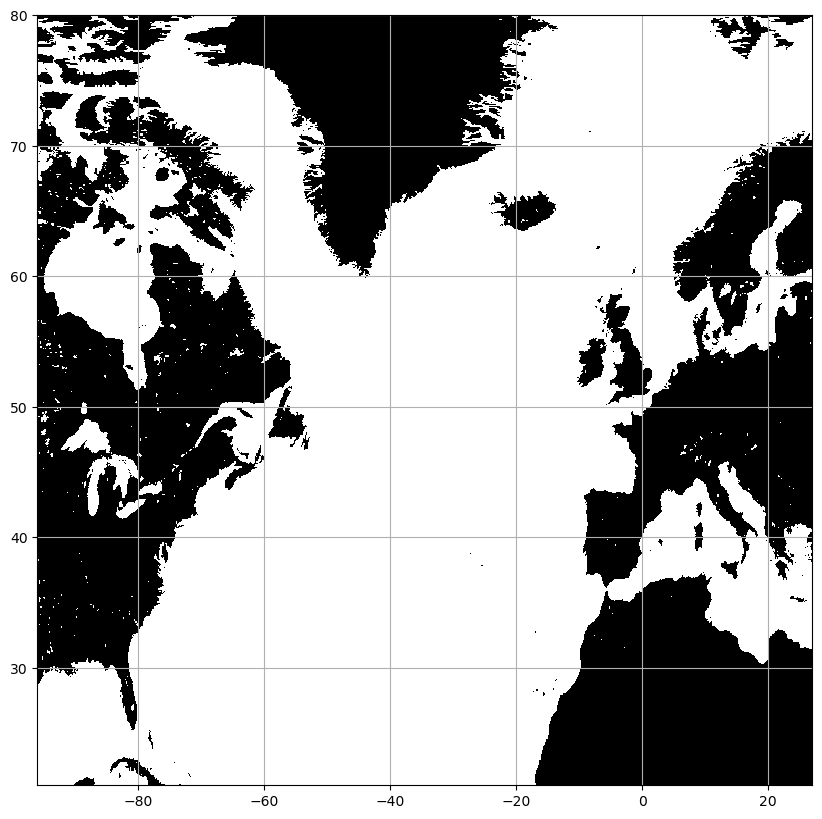

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.pcolor(lon, lat, maskchloro', cmap=plt.cm.binary_r)
plt.grid()
plt.show()

We need to process the mask to remove lakes.

In [34]:
mask2 = copy(mask);
sel2 = ((lat .>= 37.5) .& (lat .<= 43.)) 
sel1 = (lon .>= -8.2)
mask2[sel1, sel2] .= 0.;
sel1 = ((lon .>= -10) .& (lon .<= 0.))
sel2 = lat .< 20.
mask2[sel1, sel2] .= 0.;

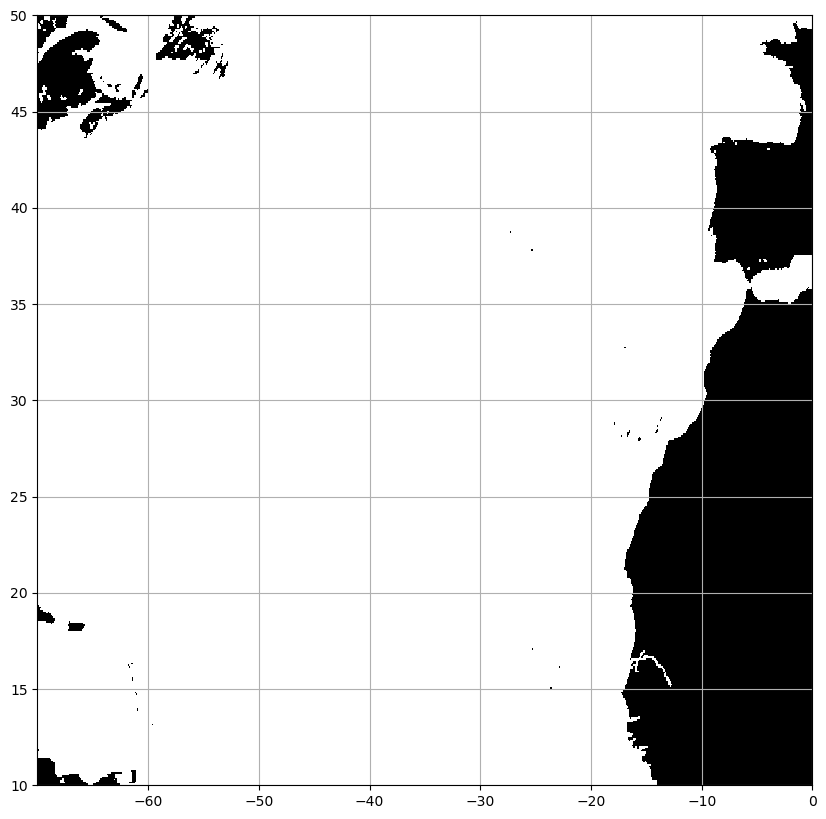

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.pcolor(lon, lat, mask2', cmap=plt.cm.binary_r)
plt.grid()
plt.show()

We will use the GEBCO bathymetry to also mask islands (to be done later... not direct).

In [12]:
SST.create_sst_file(joinpath(outputdir, "NEAtlantic_large_sst_anomalies.nc"), 
    lon, lat, times, sstanom, mask; valex=valex);

In [13]:
SST.create_sst_file(joinpath(outputdir, "NEAtlantic_large_sst.nc"), 
    lon, lat, times, sstfield, mask; valex=valex);
@info("New file written in $(outputdir)")

[ Info: New file written in /home/ctroupin/data/SST/Global/DINEOF/
┌ Warning: /home/ctroupin/Software/julia-1.8.5/share/julia/stdlib/v1.8/OpenLibm_jll/src is not an existing directory, Revise is not watching
└ @ Revise /home/ctroupin/.julia/packages/Revise/VRgaS/src/packagedef.jl:569
┌ Warning: /home/ctroupin/Software/julia-1.8.5/share/julia/stdlib/v1.8/Zlib_jll/src is not an existing directory, Revise is not watching
└ @ Revise /home/ctroupin/.julia/packages/Revise/VRgaS/src/packagedef.jl:569
┌ Warning: /home/ctroupin/Software/julia-1.8.5/share/julia/stdlib/v1.8/CompilerSupportLibraries_jll/src is not an existing directory, Revise is not watching
└ @ Revise /home/ctroupin/.julia/packages/Revise/VRgaS/src/packagedef.jl:569


In [32]:
SST.create_chloro_file(joinpath(outputdir, "NEAtlantic_large_chloro.nc"), 
    lon, lat, times, chlorofield, maskchloro; valex=valex);
@info("New file written in $(outputdir)")

[ Info: New file written in /home/ctroupin/data/Chloro/Global/DINEOF


## Check output (after running DINEOF)

In [38]:
outputfile = "/home/ctroupin/Software/DINEOF/SST-Atlantic/NEAtlantic_sst.nc"
function read_results(outputfile::String)
    NCDataset(outputfile, "r") do ds
        sst_filled = coalesce.(ds["filledSST"][:], NaN)
        return sst_filled
    end
end

read_results (generic function with 1 method)

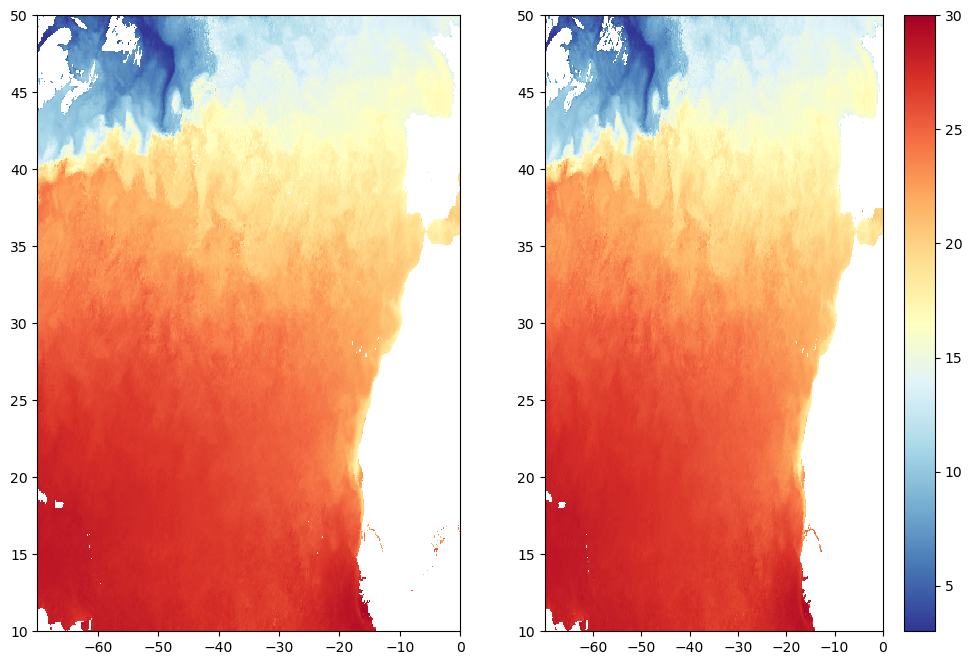

PyObject <matplotlib.colorbar.Colorbar object at 0x7fecd4209310>

In [40]:
cmap = plt.cm.RdYlBu_r
sstfilled = read_results(outputfile);
sstfield[sstfield .== -999.] .= NaN;
ntime = 142
sstmin, sstmax = 3., 30.
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(121)
ax1.pcolormesh(lon, lat, sstfield[:,:,ntime]', cmap=cmap, vmin=sstmin, vmax=sstmax)
ax2 = plt.subplot(122)
pcm2 = ax2.pcolormesh(lon, lat, sstfilled[:,:,ntime]', cmap=cmap, vmin=sstmin, vmax=sstmax)
plt.colorbar(pcm2)